In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Cihaz:", device)


Cihaz: cpu


In [2]:
data_dir = r"C:\Users\KER9\Desktop\Derin Öğrenme\NEU-DET"

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [3]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

print("Sınıflar:", full_dataset.classes)
print("Toplam örnek sayısı:", len(full_dataset))

num_samples = len(full_dataset)
train_size = int(num_samples * 0.7)
val_size   = int(num_samples * 0.15)
test_size  = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Sınıflar: ['train', 'validation']
Toplam örnek sayısı: 1800
Train: 1260, Val: 270, Test: 270


In [4]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model, criterion, dataloader, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    return total_loss / len(dataloader.dataset), acc, prec, rec, f1, y_true, y_pred


In [5]:
class SimpleCNN_Kerem(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN_Kerem, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 224 -> 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 112 -> 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)           # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(full_dataset.classes)  # 2 sınıf
model_kerem = SimpleCNN_Kerem(num_classes=num_classes).to(device)
print(model_kerem)


SimpleCNN_Kerem(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_kerem = optim.Adam(model_kerem.parameters(), lr=1e-3)
num_epochs = 10

train_losses_k = []
val_losses_k = []
val_accs_k = []
val_f1s_k = []


In [7]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model_kerem, optimizer_kerem, criterion, train_loader, device)
    val_loss, acc, prec, rec, f1, _, _ = evaluate(model_kerem, criterion, val_loader, device)

    train_losses_k.append(train_loss)
    val_losses_k.append(val_loss)
    val_accs_k.append(acc)
    val_f1s_k.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Acc:    {acc:.4f}")
    print(f"  Val F1:     {f1:.4f}")
    print("-" * 40)


Epoch 1/10
  Train Loss: 0.5098
  Val Loss:   0.5268
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 2/10
  Train Loss: 0.4810
  Val Loss:   0.4939
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 3/10
  Train Loss: 0.4763
  Val Loss:   0.4996
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 4/10
  Train Loss: 0.4741
  Val Loss:   0.5011
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 5/10
  Train Loss: 0.4592
  Val Loss:   0.4975
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 6/10
  Train Loss: 0.4516
  Val Loss:   0.4952
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 7/10
  Train Loss: 0.4559
  Val Loss:   0.5612
  Val Acc:    0.7852
  Val F1:     0.4398
----------------------------------------
Epoch 8/10
  Train Loss: 0.4509
  Val Loss:   0.

In [8]:
test_loss_k, test_acc_k, test_prec_k, test_rec_k, test_f1_k, y_true_k, y_pred_k = evaluate(
    model_kerem, criterion, test_loader, device
)

print("=== TEST SONUÇLARI (KEREM - CNN) ===")
print(f"Test Loss:      {test_loss_k:.4f}")
print(f"Test Accuracy:  {test_acc_k:.4f}")
print(f"Test Precision: {test_prec_k:.4f}")
print(f"Test Recall:    {test_rec_k:.4f}")
print(f"Test F1 Score:  {test_f1_k:.4f}")

print("\nSınıf Bazlı Rapor:")
print(classification_report(y_true_k, y_pred_k, target_names=full_dataset.classes, zero_division=0))


=== TEST SONUÇLARI (KEREM - CNN) ===
Test Loss:      0.4369
Test Accuracy:  0.7963
Test Precision: 0.3981
Test Recall:    0.5000
Test F1 Score:  0.4433

Sınıf Bazlı Rapor:
              precision    recall  f1-score   support

       train       0.80      1.00      0.89       215
  validation       0.00      0.00      0.00        55

    accuracy                           0.80       270
   macro avg       0.40      0.50      0.44       270
weighted avg       0.63      0.80      0.71       270



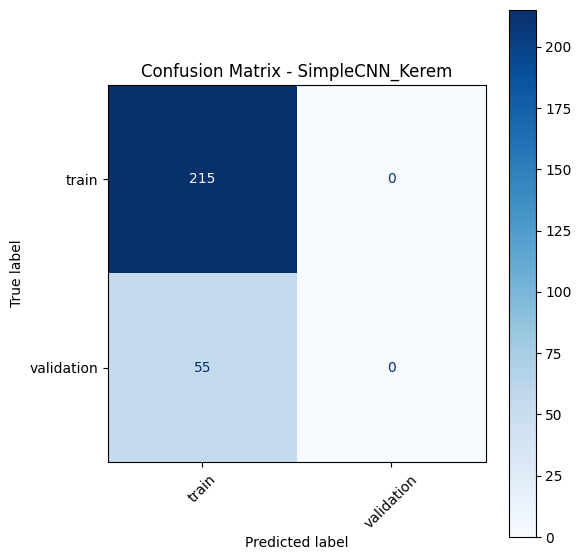

In [13]:
cm_k = confusion_matrix(y_true_k, y_pred_k)

disp_k = ConfusionMatrixDisplay(confusion_matrix=cm_k, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_k.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - SimpleCNN_Kerem")
plt.tight_layout()
plt.show()


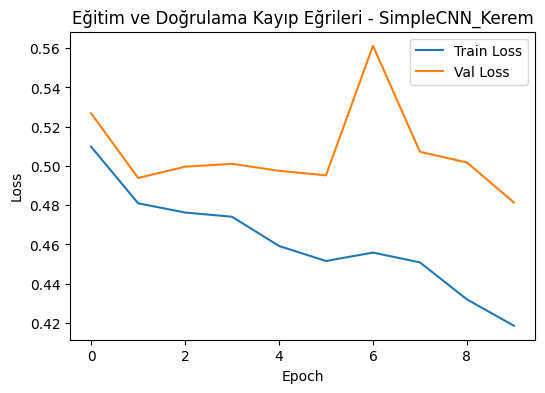

In [10]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_k, label="Train Loss")
plt.plot(val_losses_k, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıp Eğrileri - SimpleCNN_Kerem")
plt.legend()
plt.show()
